In [2]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Modelling
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import RandomizedSearchCV, KFold
import warnings

### Just test some models for now

### Import data

In [3]:
df = pd.read_csv('data/cleaned_data.csv')

In [306]:
df.head()

,Company,TypeName,OpSys,Width,Heigth,IsTouchscreen,CpuProducer,CpuSpeed (GHz),HDD,Hybrid,SSD,Flash Storage,GpuProducer,Ram (GB),Weight (kg),Price_euros
0,Apple,Ultrabook,macOS,2560,1600,No,Intel,2.3,0,0,128,0,Intel,8,1.37,1339.69
1,Apple,Ultrabook,macOS,1440,900,No,Intel,1.8,0,0,0,128,Intel,8,1.34,898.94
2,HP,Notebook,No OS,1920,1080,No,Intel,2.5,0,0,256,0,Intel,8,1.86,575.00
3,Apple,Ultrabook,macOS,2880,1800,No,Intel,2.7,0,0,512,0,AMD,16,1.83,2537.45
4,Apple,Ultrabook,macOS,2560,1600,No,Intel,3.1,0,0,256,0,Intel,8,1.37,1803.60


### Prepare X and y variables

In [4]:
X = df.drop(columns=['Price_euros'],axis=1)
y = df['Price_euros']

In [7]:
# define numerical & categorical columns
num_features = X.select_dtypes(exclude="object").columns
cat_features = X.select_dtypes(include="object").columns

print('We have {} numerical features : {}'.format(len(num_features), num_features))
print('\nWe have {} categorical features : {}'.format(len(cat_features), cat_features))

We have 9 numerical features : Index(['Width', 'Heigth', 'CpuSpeed (GHz)', 'HDD', 'Hybrid', 'SSD',
       'Flash Storage', 'Ram (GB)', 'Weight (kg)'],
      dtype='object')

We have 6 categorical features : Index(['Company', 'TypeName', 'OpSys', 'IsTouchscreen', 'CpuProducer',
       'GpuProducer'],
      dtype='object')


In [309]:
def print_cat(feature):
    print(f"Categories in {feature} variable {len(X[feature].unique())}:      ",end=" " )
    print(X[feature].unique())


In [310]:
for feature in cat_features:
    print_cat(feature=feature)

Categories in Company variable 9:       ['Apple' 'HP' 'Acer' 'Asus' 'Dell' 'Lenovo' 'Other' 'MSI' 'Toshiba']
Categories in TypeName variable 6:       ['Ultrabook' 'Notebook' 'Netbook' 'Gaming' '2 in 1 Convertible'
 'Workstation']
Categories in OpSys variable 7:       ['macOS' 'No OS' 'Windows 10' 'Linux' 'Other' 'Chrome OS' 'Windows 7']
Categories in IsTouchscreen variable 2:       ['No' 'Yes']
Categories in CpuProducer variable 2:       ['Intel' 'AMD']
Categories in GpuProducer variable 3:       ['Intel' 'AMD' 'Nvidia']


In [8]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, cat_features),
         ("StandardScaler", numeric_transformer, num_features),        
    ]
)


### Create evaliation function 

In [312]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mse)
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [313]:
# models = {
#     "Linear Regression": LinearRegression(),
#     "K-Neighbors Regressor": KNeighborsRegressor(n_neighbors=11, weights='uniform'),
#     "Decision Tree": DecisionTreeRegressor(),
#     "Random Forest Regressor": RandomForestRegressor(n_estimators=120, bootstrap=True, max_features='sqrt', random_state=1),
#     # "XGBRegressor": XGBRegressor(), 
#     # "CatBoosting Regressor": CatBoostRegressor(verbose=False),
#     # "AdaBoost Regressor": AdaBoostRegressor()
# }
# model_list = []
# r2_list =[]

# for i, model_name in enumerate(models):
#     model = models[model_name]
#     model.fit(X_train, y_train) # Train model

#     # Make predictions
#     y_train_pred = model.predict(X_train)
#     y_test_pred = model.predict(X_test)
    
#     # Evaluate Train and Test dataset
#     model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

#     model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    
#     print(model_name)
#     model_list.append(model_name)
    
#     print('Model performance for Training set')
#     print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
#     print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
#     print("- R2 Score: {:.4f}".format(model_train_r2))

#     print('----------------------------------')
    
#     print('Model performance for Test set')
#     print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
#     print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
#     print("- R2 Score: {:.4f}".format(model_test_r2))
#     r2_list.append(model_test_r2)
    
#     print('='*35)
#     print('\n')


In [314]:
kf = KFold(n_splits=5, shuffle=True)
models = {
    "Linear Regression": LinearRegression(),
    "K-Neighbors Regressor": KNeighborsRegressor(n_neighbors=5, weights='distance', p=1),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(n_estimators=100, bootstrap=True, max_features='sqrt', 
                                                     random_state=1),
    # "XGBRegressor": XGBRegressor(), 
    # "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    'GradientBoostingRegressor': GradientBoostingRegressor(random_state=1, max_features='sqrt',
                                                           n_estimators=200, learning_rate=0.1)
}

model_performance = {'Linear Regression': [], 'K-Neighbors Regressor': [], 
                     'Decision Tree': [], 'Random Forest Regressor': [], 'GradientBoostingRegressor': []}


for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    X_train = preprocessor.fit_transform(X_train)
    X_test = preprocessor.transform(X_test)

    for model_name in models:
        model = models[model_name]
        model.fit(X_train, y_train) # Train model

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        # Evaluate Train and Test dataset
        model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

        model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

        
        print(model_name)
      
        
        print('Model performance for Training set')
        print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
        print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
        print("- R2 Score: {:.4f}".format(model_train_r2))

        print('----------------------------------')
        
        print('Model performance for Test set')
        print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
        print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
        print("- R2 Score: {:.4f}".format(model_test_r2))
        model_performance[model_name].append(model_test_r2)
        
        print('='*35)
        print('\n')


Linear Regression
Model performance for Training set
- Root Mean Squared Error: 323.2253
- Mean Absolute Error: 231.4028
- R2 Score: 0.7836
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 346.2824
- Mean Absolute Error: 249.6362
- R2 Score: 0.7653


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 41.5803
- Mean Absolute Error: 9.2814
- R2 Score: 0.9964
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 344.9680
- Mean Absolute Error: 215.2384
- R2 Score: 0.7671


Decision Tree
Model performance for Training set
- Root Mean Squared Error: 41.5803
- Mean Absolute Error: 9.2814
- R2 Score: 0.9964
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 406.1884
- Mean Absolute Error: 254.7025
- R2 Score: 0.6770


Random Forest Regressor
Model performance for Training set
- Root Mean Squared Error: 249.2411
- Mean Absolute Error: 185

In [315]:
model_list = model_performance.keys()
r2_list = list(map(lambda x: np.average(x), list(model_performance.values())))

### Result

In [316]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)

,Model Name,R2_Score
4,GradientBoostingRegressor,0.838156
1,K-Neighbors Regressor,0.783201
3,Random Forest Regressor,0.769398
0,Linear Regression,0.759306
2,Decision Tree,0.722220


### Choose RandomforestRegressor

In [5]:
# separate dataset into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,random_state=42)
X_train.shape, X_test.shape

((1171, 15), (131, 15))

In [11]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [12]:
rf = RandomForestRegressor(n_estimators=100, bootstrap=True, max_features='sqrt', random_state=1)
rf= rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
score = r2_score(y_test, y_pred)*100
print(" Accuracy of the model is %.2f" %score)

 Accuracy of the model is 76.33


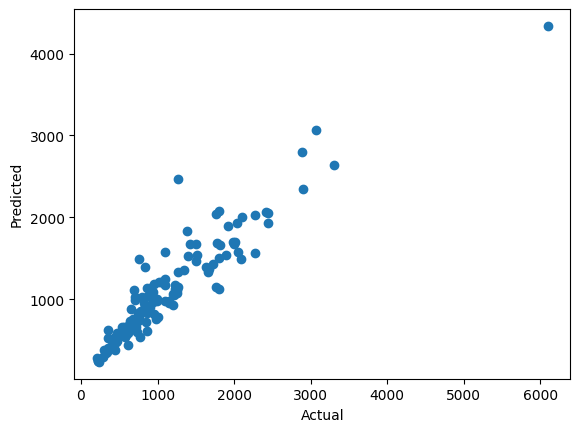

In [320]:
plt.scatter(y_test,y_pred);
plt.xlabel('Actual');
plt.ylabel('Predicted');

### Difference between predicted and actual values

In [321]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
478,675.00,701.341267,-26.341267
724,1348.48,1352.122602,-3.642602
312,2099.00,2008.835600,90.164400
851,1899.00,1538.359800,360.640200
1275,459.00,481.616200,-22.616200
...,...,...,...
848,2277.00,1559.105743,717.894257
413,789.01,859.140300,-70.130300
297,2884.86,2798.505100,86.354900
86,699.00,1106.005833,-407.005833
